<a href="https://colab.research.google.com/github/annevogel13/XAI/blob/main/XAI_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credits

Fine-tune Vision Transformers for **anything** using images found on the web.
Based on the notebook [HuggingPics.ipnb](https://colab.research.google.com/github/nateraw/huggingpics/blob/main/HuggingPics.ipynb)
and [deepfakes](https://huggingface.co/joyc360/deepfakes)

## Imports

In [2]:
%%capture

! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [3]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torchmetrics import Accuracy
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader
import pandas as pd

In [5]:
search_terms = sorted([
    "deepfake face" # be represented with 0
    "face"# be represented with 1
])

## Get Images from folder

We'll save them to a new folder named `images/` that is structured to work with [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder).

In [26]:
# mount
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [7]:
# Set the path to the training dataset
dataset_path = "/content/drive/My Drive/XAI-model/model_images"

# Create the ImageFolder dataset
ds = ImageFolder(root=dataset_path)

In [8]:
# loading generated images by the diffuser model
dataset_path_test = "/content/drive/My Drive/XAI-model/testing"

# Create the ImageFolder dataset
ds_test = ImageFolder(root=dataset_path_test)

## Initalisation of the dataset and Split into training and validation Sets


In [9]:
indices = torch.randperm(len(ds)).tolist()
# determminng how many values we need to evaluate
n_val = math.floor(len(indices) * .15)

# creating the subsets
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

## Show some examples of the training dataset


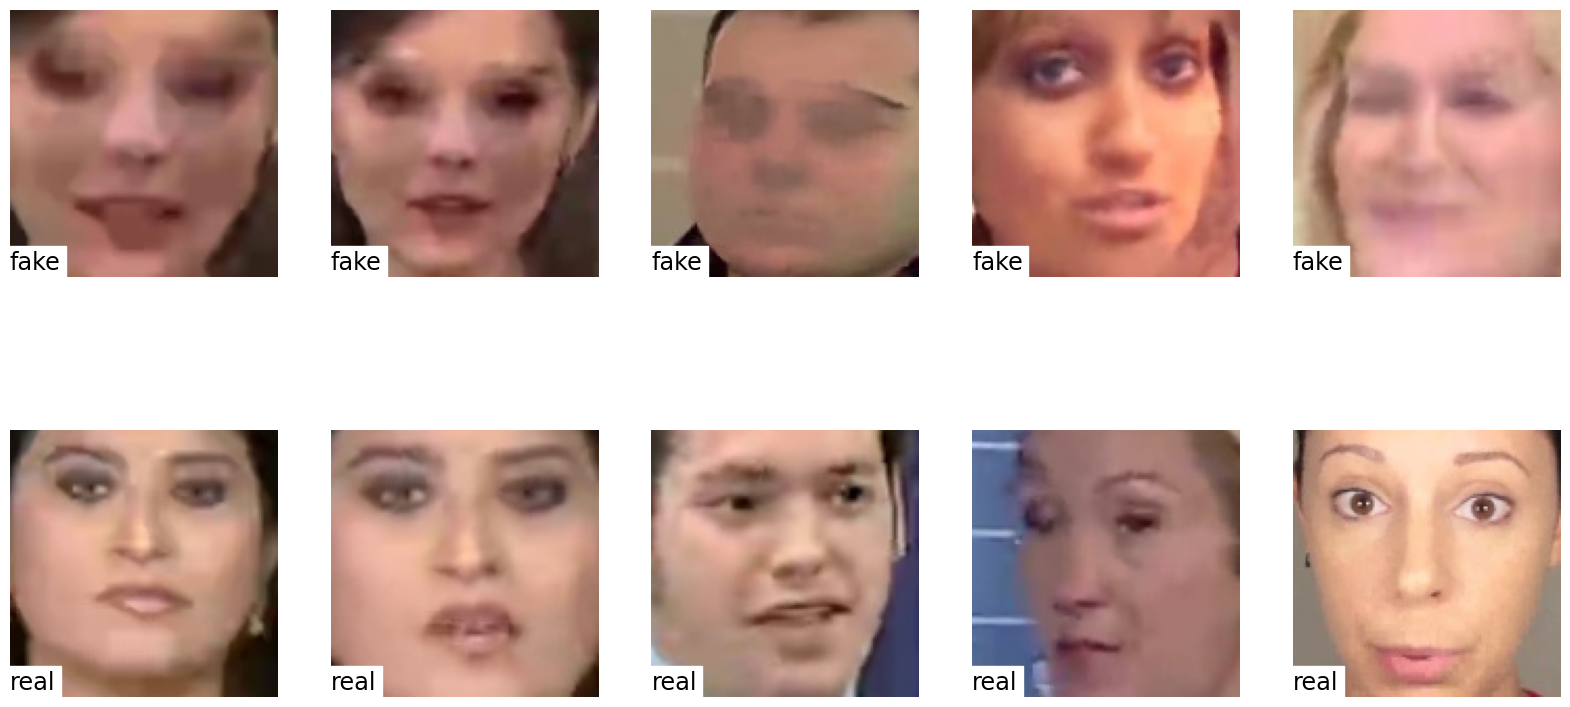

In [10]:
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):

    folder = Path(ds.root + "/" + class_name)
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

## Preparing labels for model's configuration

By adding `label2id` + `id2label` to our model's config, we'll get better labels in the inference API.

In [11]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

## Image Classification Collator

To apply our transforms to images, we'll use a custom collator class. We'll initialize it using an instance of `ViTFeatureExtractor` and pass the collator instance to `torch.utils.data.DataLoader`'s `collate_fn` kwarg.

In [12]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

## Init Feature Extractor, Model, Data Loaders


In [13]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)

collator = ImageClassificationCollator(feature_extractor)

# dataloaders
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)
ds_test_loader = DataLoader(ds_test, batch_size=8, collate_fn=collator, num_workers=2)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

⚡ We'll use [PyTorch Lightning](https://pytorchlightning.ai/) to fine-tune our model.

In [14]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task= 'binary',
            num_classes= 2
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [15]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(accelerator='gpu', devices=1, precision="16-mixed", max_epochs=10)
trainer.fit(classifier, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | BinaryAccuracy            | 0     
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.201   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## (Short) Evaluation of the model

In [16]:
# evaluation with the images from the training dataset
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([0, 1, 1, 1, 0, 1, 1, 0])
Labels: tensor([0, 1, 1, 1, 0, 1, 1, 0])


In [57]:
# evaluation with the images from the diffusion model
test_batch = next(iter(ds_test_loader))
outputs = model(**test_batch)
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', test_batch['labels'])

Preds:  tensor([1, 0, 0, 0, 1, 0, 0, 0])
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0])


In [18]:
# save the model, so that is can be reused at a later point
torch.save(model.state_dict(), '/content/drive/My Drive/XAI-model/real-fake-model.pth')

# Prediction for our dataset from the diffusion model

In [56]:
# set model to evaluation mode
model.eval()

# getting the datasets
dataset1_path = "/content/drive/My Drive/XAI-model/datasets/Dataset Stepcounts SD_1.5"
dataset2_path = "/content/drive/My Drive/XAI-model/datasets/Dataset CFG Scale SD_1.5"

# getting the csv with the parameters of the difussion model
dataset1_csv = pd.read_csv(dataset1_path+"/datasest_stepcount.csv")
dataset2_csv = pd.read_csv(dataset2_path+"/dataset_cfg_SD_1-5.csv")

# prepare the imageFolder, so that we can loop over it
ds1_XAI = ImageFolder(root=dataset1_path+"/images")
ds2_XAI = ImageFolder(root=dataset2_path+"/images")

In [46]:
# re-mount, to make sure that the path names are up to date
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [55]:
# create empty list to store the predictions in
model_predictions = []
# intialize a counter so that we have a feel for the progress
counter = 0
# loop through all the images paths in the dataset
for value in dataset1_csv['Image Path']:
    # intialize counters
    counter += 1
    # create the path_images
    path_image = "/content/drive/My Drive/XAI-model/datasets/Dataset Stepcounts SD_1.5" + value[1:]
    image = Image.open(path_image)
    # calculating the inputs
    inputs = feature_extractor(images=image, return_tensors="pt")
    # getting the output
    outputs = model(**inputs)
    # recalculating with softmax the "official" prediction
    pred = outputs.logits.softmax(1).argmax(1)
    # add it to the list
    model_predictions.append( pred)
    # output the process
    print(value, pred,  int((counter/len(dataset1_csv))*100))

./images/dataset_stepcount/0001_10.png tensor([1]) 0
./images/dataset_stepcount/0002_10.png tensor([1]) 0
./images/dataset_stepcount/0003_10.png tensor([1]) 0
./images/dataset_stepcount/0004_10.png tensor([1]) 0
./images/dataset_stepcount/0005_10.png tensor([1]) 0
./images/dataset_stepcount/0006_10.png tensor([1]) 0
./images/dataset_stepcount/0007_10.png tensor([1]) 0
./images/dataset_stepcount/0008_10.png tensor([0]) 1
./images/dataset_stepcount/0009_10.png tensor([0]) 1
./images/dataset_stepcount/0010_10.png tensor([1]) 1
./images/dataset_stepcount/0011_10.png tensor([0]) 1
./images/dataset_stepcount/0012_10.png tensor([1]) 1
./images/dataset_stepcount/0013_10.png tensor([1]) 1
./images/dataset_stepcount/0014_10.png tensor([1]) 1
./images/dataset_stepcount/0015_10.png tensor([0]) 2
./images/dataset_stepcount/0016_10.png tensor([0]) 2
./images/dataset_stepcount/0017_10.png tensor([1]) 2
./images/dataset_stepcount/0018_10.png tensor([1]) 2
./images/dataset_stepcount/0019_10.png tensor(

In [43]:
model_predictions

# extracting the value from the tensor
predictions = [item_tensor.item() for item_tensor in model_predictions]
# adding the values to the dataframe
dataset1_csv["prediction"] = predictions

# calculating some statics, getting the number of values for each prediction
value_counts = dataset1_csv["prediction"].value_counts()
# calculate the precentages
percentage_counts = (value_counts / len(dataset1_csv)) * 100
# adding the result into a seperate dataframe (nice formatting)
result_df = pd.DataFrame({
    'Value': value_counts.index,
    'Count': value_counts.values,
    'Percentage': percentage_counts.values
})

# 0 is fake, 1 is real
print(result_df)

   Value  Count  Percentage
0      1    609   84.583333
1      0    111   15.416667


In [58]:
# (same process as the dataset above)
model_predictions_2 = []
counter_2 = 0
for value in dataset2_csv['Image Path']:
    counter_2 += 1
    path_image = "/content/drive/My Drive/XAI-model/datasets/Dataset CFG Scale SD_1.5" + value[1:]
    image = Image.open(path_image)
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    pred = outputs.logits.softmax(1).argmax(1)
    model_predictions_2.append( pred)
    print(value, pred, int((counter_2/len(dataset2_csv))*100))

./images/cfg/0001_2-5.png tensor([1]) 0
./images/cfg/0002_2-5.png tensor([1]) 0
./images/cfg/0003_2-5.png tensor([1]) 1
./images/cfg/0004_2-5.png tensor([1]) 1
./images/cfg/0005_2-5.png tensor([1]) 1
./images/cfg/0006_2-5.png tensor([1]) 2
./images/cfg/0007_2-5.png tensor([1]) 2
./images/cfg/0008_2-5.png tensor([1]) 2
./images/cfg/0009_2-5.png tensor([1]) 3
./images/cfg/0010_2-5.png tensor([1]) 3
./images/cfg/0011_2-5.png tensor([1]) 3
./images/cfg/0012_2-5.png tensor([1]) 4
./images/cfg/0013_2-5.png tensor([1]) 4
./images/cfg/0014_2-5.png tensor([1]) 4
./images/cfg/0015_2-5.png tensor([1]) 5
./images/cfg/0016_2-5.png tensor([1]) 5
./images/cfg/0017_2-5.png tensor([1]) 5
./images/cfg/0018_2-5.png tensor([1]) 6
./images/cfg/0019_2-5.png tensor([0]) 6
./images/cfg/0020_2-5.png tensor([1]) 6
./images/cfg/0021_2-5.png tensor([1]) 7
./images/cfg/0022_2-5.png tensor([1]) 7
./images/cfg/0023_2-5.png tensor([1]) 7
./images/cfg/0024_2-5.png tensor([1]) 8
./images/cfg/0025_2-5.png tensor([1]) 8


In [53]:
# (same process as the dataset above)
model_predictions_2

predictions_2 = [item_tensor.item() for item_tensor in model_predictions_2]
dataset2_csv["prediction"] = predictions_2

value_counts = dataset2_csv["prediction"].value_counts()
percentage_counts = (value_counts / len(dataset2_csv)) * 100

result_df = pd.DataFrame({
    'Value': value_counts.index,
    'Count': value_counts.values,
    'Percentage': percentage_counts.values
})

# 0 is fake, 1 is real
print(result_df)

   Value  Count  Percentage
0      1    238   82.638889
1      0     50   17.361111


In [54]:
# saving the new csv's to drive, where they can be used for the analyzing
dataset1_csv.to_csv("/content/drive/My Drive/XAI-model/datasest_stepcount_with_prediction.csv", index=True)
dataset2_csv.to_csv("/content/drive/My Drive/XAI-model/dataset_cfg_SD_1-5_with_prediction.csv", index=True)